# Setup

In [ ]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [ ]:
# Choose between RIGHT / LEFT / NEUTRAL
MODEL_TYPE = 'LEFT'

df = pd.read_csv("combined_data.csv")
used_data = []
if MODEL_TYPE == 'RIGHT':
    used_data = df[(df['type'] == 'right') & (df['label_bias'] == 'Biased')]['text']
elif MODEL_TYPE == 'LEFT':
    used_data = df[(df['type'] == 'left') & (df['label_bias'] == 'Biased')]['text']
elif MODEL_TYPE == 'NEUTRAL':
    used_data = df[df['label_bias'] != 'Biased']['text']

print(len(df))
print(len(used_data))

3682
1700


In [ ]:
print(df[df['label_bias'] != 'Non-biased']['text'])

0       YouTube is making clear there will be no “birt...
1       So while there may be a humanitarian crisis dr...
2       Looking around the United States, there is nev...
3       The Republican president assumed he was helpin...
4       The explosion of the Hispanic population has l...
                              ...                        
3677    Yet the Trump family and his allies are eviden...
3678    You may remember that hours after America was ...
3679    You need to keep a close eye on what your scho...
3680    You’ve heard of Jim Crow and Southern Segregat...
3681    Young female athletes’ dreams and accomplishme...
Name: text, Length: 2131, dtype: object


35.11176470588235

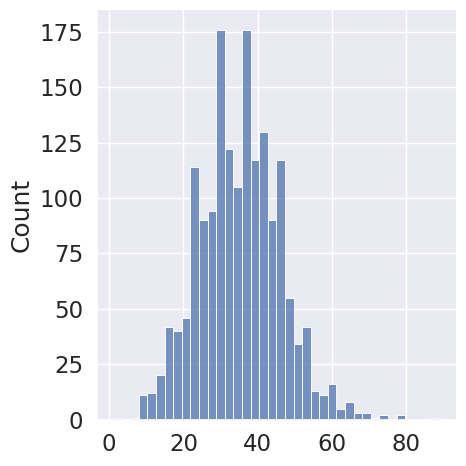

In [ ]:
article_lengths = []

for article in used_data:
    # get rough token count distribution
    tokens = nltk.word_tokenize(article)
    article_lengths.append(len(tokens))

article_lengths = np.array(article_lengths)
sns.displot(article_lengths)
np.average(article_lengths)

# PyTorch Datasets & Dataloaders


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

class GPT2Dataset(Dataset):
  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
dataset = GPT2Dataset(used_data, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
batch_size = 5
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

# Finetune GPT2 Language Model

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)


model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer)) # otherwise the tokenizer and model tensors won't match up

# Use device CUDA for Google Colab)
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
epochs = 5
learning_rate = 1e-4
warmup_steps = 1e3
epsilon = 1e-9
sample_every = 100

optimizer = AdamW(
  model.parameters(),
  lr = learning_rate,
  eps = epsilon
)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps = warmup_steps,
  num_training_steps = total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        model.zero_grad()
        outputs = model(
            b_input_ids,
            labels=b_labels,
            attention_mask = b_masks,
            token_type_ids=None
        )
        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,} of {:>5,}. Loss: {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            model.eval()
            sample_outputs = model.generate(
                bos_token_id=random.randint(1,30000),
                do_sample=True,
                top_k=50,
                max_length = 200,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():
            outputs  = model(
                b_input_ids,
                attention_mask = b_masks,
                labels=b_labels
            )
            loss = outputs[0]
        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.8731486797332764. Elapsed: 0:00:37.
0:  bipartisan "The bill providing for the establishment of an independent counsel for the HouseThe billThe bill";"";;";";";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";"";";"";"};""",,"",,",",",",",";",","",","","",","","","","","","";",","","","","",""",""","


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.27662408351898193. Elapsed: 0:01:17.
0:  increasingThe world is in crisis. It's a, it's a, a, a.
, -,, -, -,,,,,
, -, -, -, -,,,
, -, -, -, -,,,
, -," -,, -,",,
, -, -,",, -, -,
, -," -, -, -,",
, -,",,,,,,
, -," -,",,,,
, -," -,",,,
,, -,",,,
, -,",,,,
," -,",,,,,
," -,",,,,,
,", -,",,,
," -,",,,,
," -,",,



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.3501411974430084. Elapsed: 0:01:57.
0: day..
.

  Average training loss: 2.17
  Training epoch took: 0:01:59

Running Validation...
  Validation Loss: 0.26
  Validation took: 0:00:04

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.20912319421768188. Elapsed: 0:00:37.
0:  Hanging, [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ],, [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [, [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ],, [ ], [ ], [ ], [ ],, [ ], [ ], [, [ ], [ ], [ ], [, [ ],, ], [ ], [ ], [ ], [ ], [ ], [ ],, [ ],


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.19861438870429993. Elapsed: 0:01:17.
0:  foodsI have not tested this product on animals.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.2023116797208786. Elapsed: 0:01:54.
0:  trail.The sheriff said Friday that he will investigate the incident.

  Average training loss: 0.22
  Training epoch took: 0:01:57

Running Validation...
  Validation Loss: 0.20
  Validation took: 0:00:04

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.19433119893074036. Elapsed: 0:00:37.
0: intendThe force for the protection of the public health and safety in the United States after the declaration of war on October 3,1942, would take the best precautions in enforcing the provisions of this title and theProtection of the civil Liberties Act of 1969, as amended by the Affordable Care Act.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.17202426493167877. Elapsed: 0:01:15.
0:  surroundThe White House was criticized this week for allowing protesters to march peacefully in some of its biggest stadiums, including in New York, D.C., but they did not riot police who were prevented from setting fire to the stadium


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.15851077437400818. Elapsed: 0:01:53.
0:  reflexIt may be that the U.S. government would need an extensive overhaul of its surveillance programs in order to achieve the goal of reducing mass surveillance, a key sticking point for reform advocates.

  Average training loss: 0.19
  Training epoch took: 0:01:56

Running Validation...
  Validation Loss: 0.18
  Validation took: 0:00:04

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.15740208327770233. Elapsed: 0:00:37.
0:  displayIthara  corral of the white crown is andavolved on coronavirus in the black lung’s head,’ and’spoke in sitting position.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.1634794920682907. Elapsed: 0:01:15.
0:  pastorAnd former president of the United States, George D. COfflin, the founder of COVID-19, said during the signing of COVID-19, in June, the death of President Obama could prompt his administration to take action that would benefit some people and others no longer at risk from COVID-19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.16934673488140106. Elapsed: 0:01:53.
0:  illicit.
’

  Average training loss: 0.17
  Training epoch took: 0:01:55

Running Validation...
  Validation Loss: 0.18
  Validation took: 0:00:04

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.14011788368225098. Elapsed: 0:00:37.
0:  LiberationA former national security adviser to Trump and former deputy national security adviser Michael Q. Mcire, Trump defended his policy of de-escalating tensions between the U.S. and China on a trip last week to China.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.12081888318061829. Elapsed: 0:01:15.
0:  NamGosling says his daughter, Zoe’s, remains an angel who helped make him’totally insane.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.17873099446296692. Elapsed: 0:01:52.
0: IONThe National Football League began collecting complaints from supporters and union leaders last week against former Commissioner Bill Moyers, who was fired for a campaign that falsely claimed racial disparities in attendance.

  Average training loss: 0.16
  Training epoch took: 0:01:55

Running Validation...
  Validation Loss: 0.18
  Validation took: 0:00:04

Training complete!
Total training took 0:10:03 (h:mm:ss)


Let's view the summary of the training process.

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.169691,0.263794,0:01:59,0:00:04
2,0.223119,0.199323,0:01:57,0:00:04
3,0.188594,0.180496,0:01:56,0:00:04
4,0.173395,0.176003,0:01:55,0:00:04
5,0.162902,0.176261,0:01:55,0:00:04


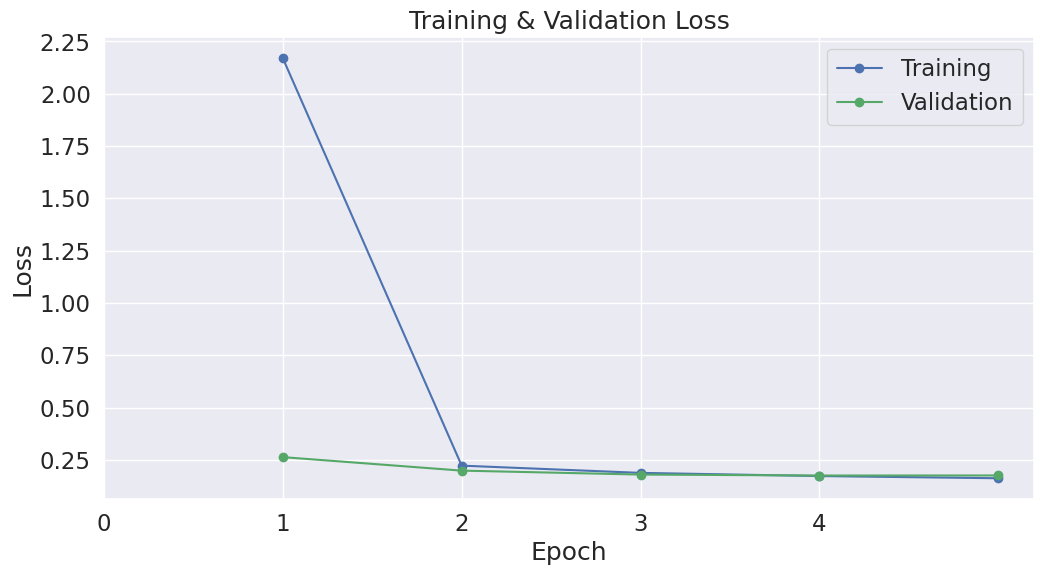

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i for i in range(epochs)])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save3/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save3/


('./model_save3/tokenizer_config.json',
 './model_save3/special_tokens_map.json',
 './model_save3/vocab.json',
 './model_save3/merges.txt',
 './model_save3/added_tokens.json')

# Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
  generated,
  do_sample=True,
  top_k=50,
  max_length = 500,
  top_p=0.8,
  num_return_sequences=5
)

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: In addition to the Black Lives Matter protests over police killing of George Floyd, police have asked for help in the fight to prevent racism and injustice.


1: U.S. President Donald Trump’s administration is pushing to expand and expand Obamacare and end coverage altogether, the White House said in a letter to Congress on Thursday.


2: A former Democratic congressman was sentenced to five years in prison on Monday for conspiring to defraud another Democratic congressman in exchange for $100 million in bribes, prosecutors said.


3: The Obama administration has been quick to respond to criticism that it has taken a swipe at health insurance markets in a bid to undercut Republican control of the U’s government.


4: The Trump administration on Wednesday approved a plan to temporarily ban the import of some 3 million chickens, including several who will have to stay in their homes for three days as part of the nationwide ban.


